## Image Retrieval From Text

Now that we can process a video and find it's encoded vector, I want to be able to match images to a given text input. Instead of matching an image to a label, we want to reverse the process. I want to do this by maximizing the dot product between the encoded vectors for the images and text.

In [79]:
import cv2
import numpy as np
import os
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image
import os
import clip
import torch
from torchvision.datasets import CIFAR100

In [80]:
# To test this on, we will use the CIFAR dataset again.
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

Files already downloaded and verified


In [81]:
# For simplicity, we will use the first 10 images in the dataset
images = [image for image, class_id in cifar100][:10]
images.append(Image.open("frame0.jpg"))

In [82]:
# for simplicity we can use the function we already defined to do this, except we are
# inputting images, so we modify it a bit
def apply_clip(frames, model, preprocess, device = "cpu"):
    image_inputs = [preprocess(image).unsqueeze(0).to(device) for image in frames]
    
    with torch.no_grad():
        image_features = [model.encode_image(image_input) for image_input in image_inputs]
        
    return image_features

In [83]:
model, preprocess = clip.load("ViT-B/32")

In [84]:
image_features = torch.cat(apply_clip(images, model, preprocess))

Now we have a list of encoded vectors, exactly what we want. Let's create a text input

In [117]:
text_input = clip.tokenize("a photo of a camel")
with torch.no_grad():
    text_features = model.encode_text(text_input)

Now let's find the dot product between this and each encoded image.

In [118]:
# First normalize each vector
image_features /= image_features.norm(dim=-1, keepdim=True) 
text_features /= text_features.norm(dim=-1, keepdim=True)

In [120]:
similarity = (100 * text_features @ image_features.T).softmax(dim=-1)

In [121]:
similarity

tensor([[2.2930e-04, 1.0709e-03, 2.0246e-02, 3.7623e-03, 2.8802e-03, 2.2603e-04,
         9.6594e-01, 3.6589e-03, 1.6958e-03, 2.7683e-04, 9.4071e-06]])

In [122]:
values, indices = similarity[0].topk(5)

In [123]:
values[0].item()

0.9659440517425537

With 96.59%, the top image is:


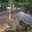

In [124]:
print(f"With {100*values[0].item():.2f}%, the top image is:")
images[indices[0]]